# LPT Lightcone Simulation

This notebook builds a full lightcone using Lagrangian Perturbation Theory (LPT). While notebook 01 used a single scale factor, here we pass an **array** of scale factors to `lpt`, which produces density maps on spherical shells at each redshift.

The Zel'dovich approximation displaces particles from Lagrangian positions **q** to Eulerian positions:

$$\mathbf{x}(a) = \mathbf{q} + D(a)\,\boldsymbol{\Psi}(\mathbf{q})$$

The `ts` parameter controls how shells are defined:
- **Scalar**: single snapshot (returns `ParticleField`)
- **1D array**: center scale factors for lightcone shells
- **2D array** `(n_shells, 2)`: explicit near/far scale factors per shell

## Setup

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"


import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_fli as jfli
import matplotlib.pyplot as plt

print(f"Devices {jax.devices()}")
jax.print_environment_info()

Devices [CudaDevice(id=0)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh048', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
XLA_PYTHON_CLIENT_MEM_FRACTION=0.95

$ nvidia-smi
Tue Feb 17 21:54:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |        

## Simulation Parameters

In [21]:
key = jax.random.PRNGKey(0)
resolution = 600
mesh_size = (resolution,) * 3
box_size = (1500.0, 1500.0, 1500.0)
nside = 256
flatsky_npix = (256,) * 2
field_size = (10, 10)
nb_shells = 3
cosmo = jc.Planck18()

## Initial Conditions

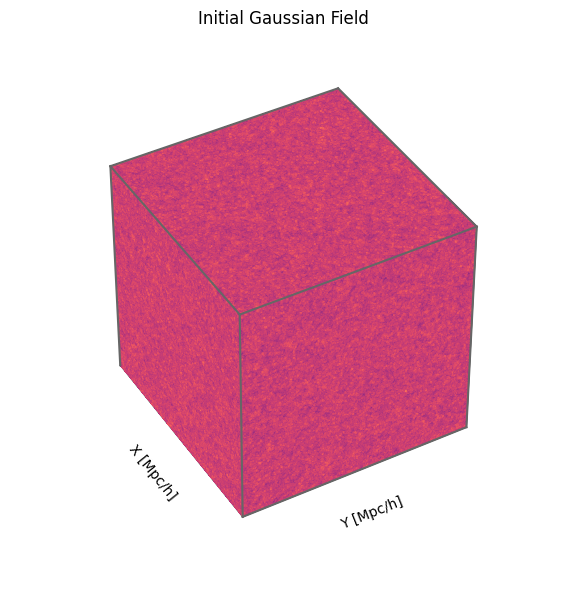

In [22]:
initial_field = jfli.gaussian_initial_conditions(
    key,
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)
initial_field.show(
    labels=["X [Mpc/h]", "Y [Mpc/h]", ""],
    colorbar=False,
    titles=["Initial Gaussian Field"],
)

## Lightcone Shell Configuration

`compute_lightcone_shells` divides the volume between the observer and the box boundary into `nb_shells` radial bins, returning comoving centers and corresponding scale factors. The shell geometry is derived from the box size and observer position stored in the `DensityField`.

Shell comoving centers [Mpc/h]: [625. 375. 125.]
Shell scale factors: [0.81966517 0.88580968 0.95972042]
Shell redshifts: [0.22001036 0.12891067 0.04197012]


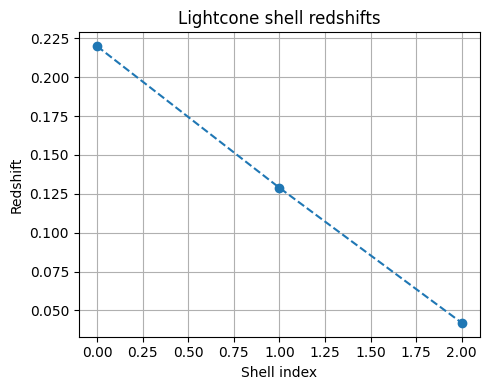

In [23]:
r_center, a_center = jfli.compute_lightcone_shells(cosmo, initial_field, nb_shells)
z_center = jc.utils.a2z(a_center)

print(f"Shell comoving centers [Mpc/h]: {r_center}")
print(f"Shell scale factors: {a_center}")
print(f"Shell redshifts: {z_center}")

fig = plt.figure(figsize=(5, 4))
plt.plot(jnp.arange(nb_shells), z_center, linestyle="--", marker="o")
plt.xlabel("Shell index")
plt.ylabel("Redshift")
plt.title("Lightcone shell redshifts")
plt.grid(True)
plt.tight_layout()
plt.show()

## Timesteps Explained

When we pass the 1D array `a_center` to `lpt`, the function:
1. Computes bin edges from the center values
2. At each shell, evaluates LPT displacements at the center scale factor
3. Paints particles whose comoving distances fall within the shell boundaries

Without a `painting` option, `lpt` returns raw `ParticleField` objects. With `PaintingOptions`, it paints on-the-fly and returns density maps directly.

## LPT with Spherical Painting

In [24]:
spherical_dens, _ = jfli.lpt(
    cosmo,
    initial_field,
    ts=a_center,
    order=1,
    painting=jfli.PaintingOptions(target="spherical", scheme="bilinear"),
)

print(f"Output type: {type(spherical_dens).__name__}")
print(f"Shape: {spherical_dens.shape} (n_shells, npix)")
print(f"NSIDE: {spherical_dens.nside}")

Output type: SphericalDensity
Shape: (3, 786432) (n_shells, npix)
NSIDE: 256


## Visualize Spherical Shells

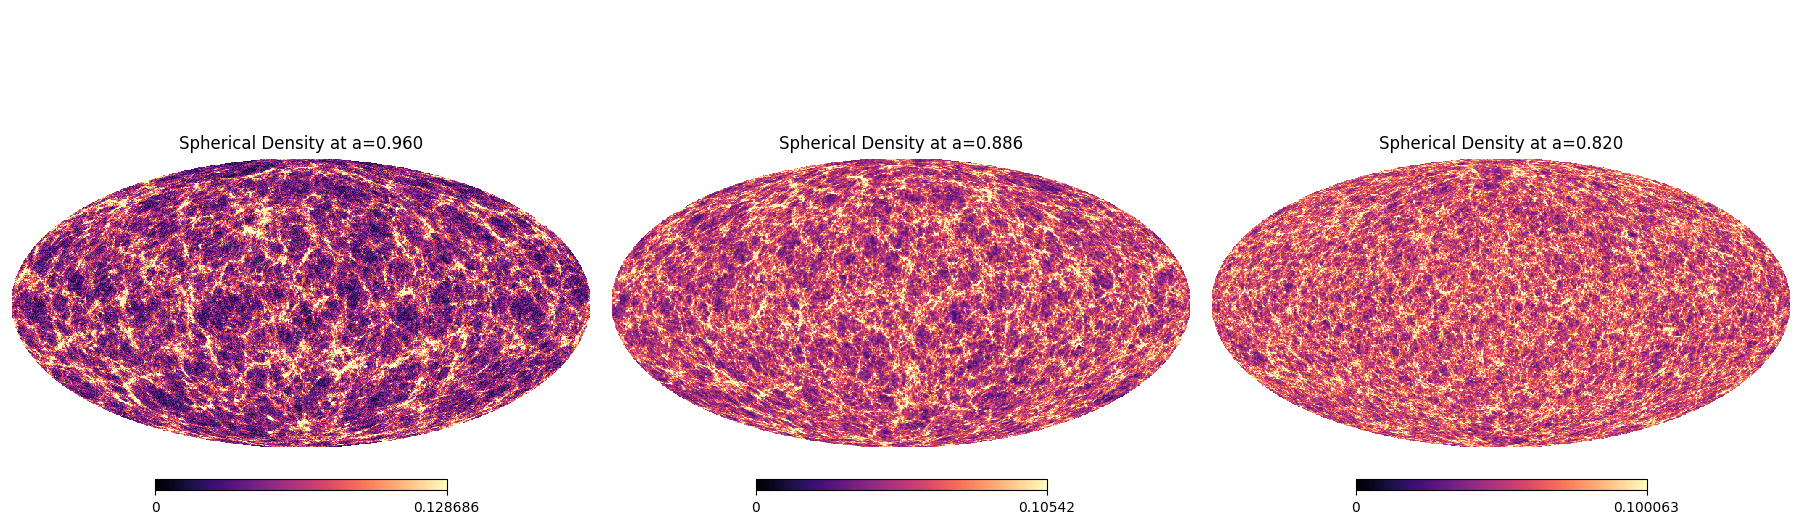

In [25]:
spherical_dens.show(ncols=3)

## Theory Comparison

For each shell, we define a top-hat redshift distribution spanning the shell boundaries and compute the predicted angular power spectrum using `compute_theory_cl`. The measured $C_\ell$ from `angular_cl` should agree with theory at large scales (low $\ell$), with deviations at small scales due to the finite particle resolution and CIC painting.

In [26]:
# Build redshift distributions for each shell
r_center = spherical_dens.comoving_centers
r_width = spherical_dens.density_width

z_near, z_far = jc.utils.a2z(jc.background.a_of_chi(cosmo, jnp.array([r_center - r_width / 2, r_center + r_width / 2])))
nz_s = [jfli.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]

# Compute theory
LMAX = 3 * nside
ells = jnp.arange(LMAX)
theory_cl_ps = jax.jit(jfli.compute_theory_cl, static_argnames=["probe_type", "nonlinear_fn", "cross"])(
    cosmo,
    ell=ells,
    z_source=nz_s,
    probe_type="number_counts",
    nonlinear_fn="linear",
    cross=False,
)
sim_cl = spherical_dens.to(jfli.units.OVERDENSITY).angular_cl(method="healpy")
lc = spherical_dens / spherical_dens.mean(axis=-1, keepdims=True) - 1
sim_single_meancl = lc.angular_cl(method="healpy")

/tmp/ipykernel_237733/3994071433.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


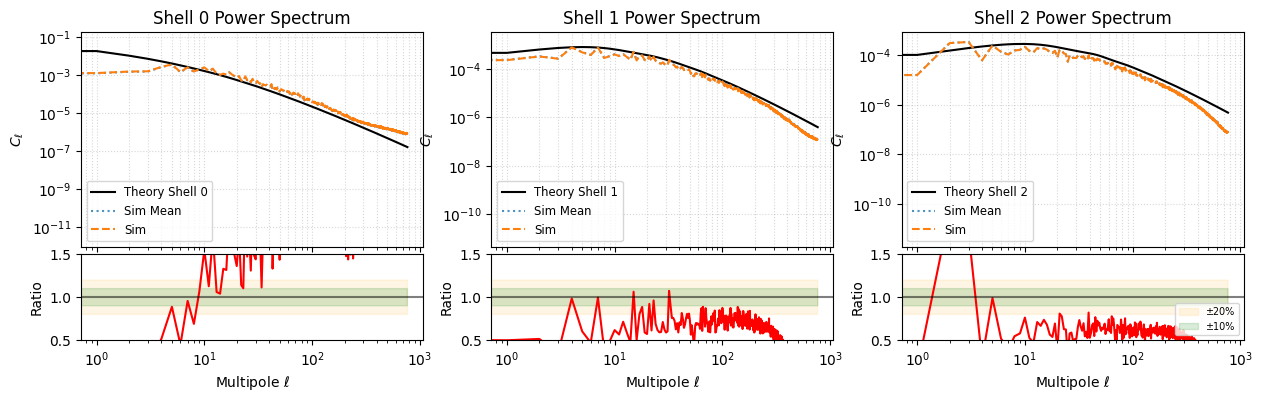

In [27]:
# Assuming nb_shells = 3 based on your 2x3 subplot call
fig, axes = plt.subplots(
    2, nb_shells, figsize=(15, 4), sharex="col", gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05}
)

for i in range(nb_shells):
    ax_top = axes[0, i]
    ax_bot = axes[1, i]

    # 1. Main Power Spectrum Plot (Top Row)
    theory_cl_ps[i].plot(ax=ax_top, label=f"Theory Shell {i}", color="black")
    sim_single_meancl[i].plot(ax=ax_top, label="Sim Mean", linestyle=":", alpha=0.8)
    sim_cl[i].plot(ax=ax_top, label="Sim", linestyle="--")

    ax_top.set_title(f"Shell {i} Power Spectrum")
    ax_top.set_ylabel(r"$C_\ell$")
    ax_top.legend(fontsize="small")

    # 2. Ratio Plot (Bottom Row)
    ratio = sim_cl[i] / theory_cl_ps[i]
    ax_bot.semilogx(ells, ratio, color="red", linewidth=1.5)

    # Reference lines and tolerance zones
    ax_bot.axhline(1, color="black", linestyle="-", alpha=0.5)
    ax_bot.fill_between(ells, 0.8, 1.2, alpha=0.1, color="orange", label="±20%")
    ax_bot.fill_between(ells, 0.9, 1.1, alpha=0.15, color="green", label="±10%")

    ax_bot.set_xlabel(r"Multipole $\ell$")
    ax_bot.set_ylabel("Ratio")
    ax_bot.set_ylim(0.5, 1.5)

    # Only show the ratio legend on the first or last plot to save space
    if i == nb_shells - 1:
        ax_bot.legend(loc="lower right", fontsize="x-small")

plt.tight_layout()
plt.show()